# Introduction

Some elite pass defense performances show up in NFL box scores like the audio guy at a concert: they are doing their job correctly if you don’t notice them. For example, Nnamdi Asomugha was awarded First-Team All-Pro for elite cornerback play in 2010 [with only six pass deflections and zero interceptions on the season](https://www.nfl.com/players/nnamdi-asomugha/stats/career). His great play passed the "eye test", but two of the most visible statistics associated with individual pass defense did not fully reflect his performance.

This report develops a methodology to identify top pass defenders through a non-traditional metric and briefly investigates receiver-defender height disparity as a potential predictor of pass play success. The following two questions are posed:

* **When targeted, which players excel at defending the pass in man and zone coverage schemes?**
* **Does the height difference between a receiver and defender influence defensive performance?**

To begin answering these questions, each play during the 2018 season needs to have:

1.	A man or zone coverage scheme label, and 
2.	A value for pass attempt difficulty, to ultimately provide a baseline for comparison between players.


# Predicting Man/Zone Coverage


The 2021 NFL Big Data Bowl competition provided labeled coverages for each play during Week 1.  The man/zone classifier developed in this report attempts to maintain generality from week-to-week and team-to-team by only looking at player tracking data within the play without considering game situation, teams, or unique players.

Various aspects of the play are quantified at the snap, a “freeze frame” after 1.5 seconds, and cumulative until a pass/fumble/sack event or a maximum of 4 seconds to remove any influence of extended play improvisation. The “freeze frame” allows time for the true scheme to develop out of the potentially deceptive pre-snap look and also determine which players in the tracking data are rushing the passer instead of covering. The 4-second max threshold was determined from an accuracy optimization exercise when developing the final classifier.

Over 40 different features were generated as potential predictors encompassing many different aspects of the play, averaged into a single value for the play:

* Features for distance between players, speed, and various ratios as proposed in [this publication](https://arxiv.org/abs/1906.11373) 
* Percentage of time a defender is facing the line of scrimmage/QB
* Number of defenders in coverage
* Number of defenders deep at the snap and freeze frame (10+ yards past line of scrimmage)
* Outer receiver-defender pairs: ratio of the length of the receiver route to the final distance between the pair
* Outermost defenders inside/outside leverage: at the snap and average throughout the play
* Depth of CBs at the snap and freeze frame

An iterative study was done to select the classification algorithm, downselect features, and confirm no overfitting based on 5-fold cross validation during training. A 20% holdout set was used to evaluate expected model performance. The following 7 features are used in the final linear SVC model (pictorial representation shown in the figure below), in order of importance:  

* **rec_space_play_mean:** Average distance from each offensive receiver beyond the line of scrimmage to the nearest coverage defender
* **depth_play_mean:** Average depth past the line of scrimmage of all coverage defenders
* **cb_depth_snap_min:** Depth of the cornerback closest to the line of scrimmage at the snap
* **dist_cover_play_mean:** Average distance from each coverage defender to the closest offensive receiver
* **dist_shadow_out_play_mean:** Average inside/outside leverage of outer defenders to outer receivers (players paired at the snap)
* **n_deep_frz:** Number of defenders 10+ yards past the line of scrimmage at the freeze frame
* **speed_play_var:** Average variance of the speed of each coverage defender



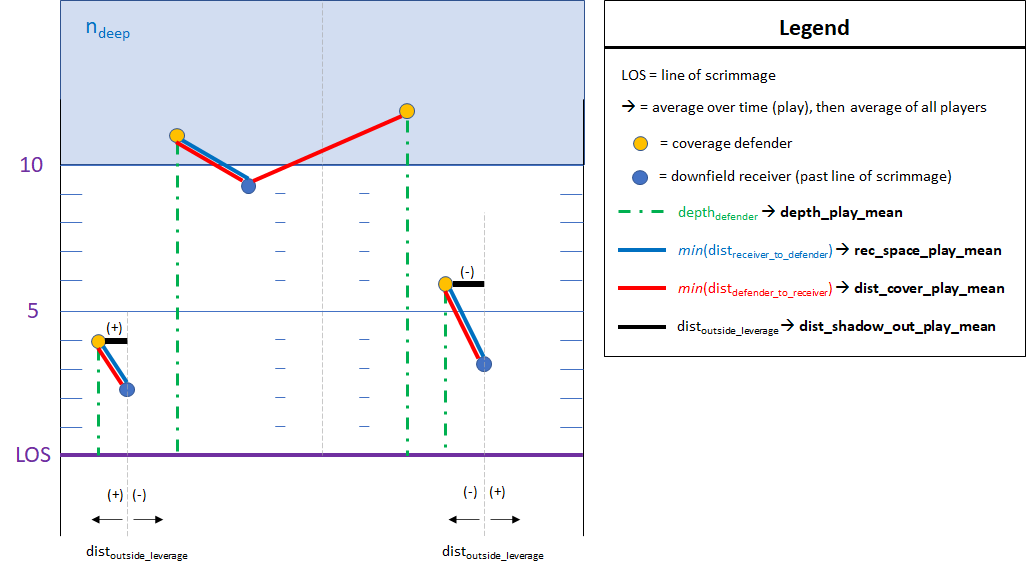

In [12]:
from IPython.display import Image
Image('../input/bdb-2021-figures/model_features.png', width=800)

The model's confusion matrix for the holdout set Week 1 plays is shown below.

|             | **Predicted Man** | **Predicted Zone** | Recall |
|-------------|:-------------:|:--------------:|:------:|
| **Actual Man**  | 45            | 23             | 66%    |
| **Actual Zone** | 13            | 125            | 91%    |
| Precision   | 78%           | 84%            | **Accuracy: 83%** (206 total) |

The model accuracy for the holdout set is on-par with the 85% and 84% average accuracies for the cross-validation training and test sets, respectively. The model is less accurate classifying actual man coverage plays than zone, but the precision is balanced. For an aggregate and comparative analysis over the course of a season, this is acceptable, while taking note that any results for man coverage have an artificially deflated sample size.

## Model Validation

A comparison of the model’s predictions for Week 1 plays vs. down, distance, location on field, quarter, and time-to-release confirms that misclassifications do not follow a pattern with respect to game situation (not shown).

Predictions were generated for all valid plays of Weeks 2-17. The percentage of plays each team played in man coverage over the entire season is shown below.

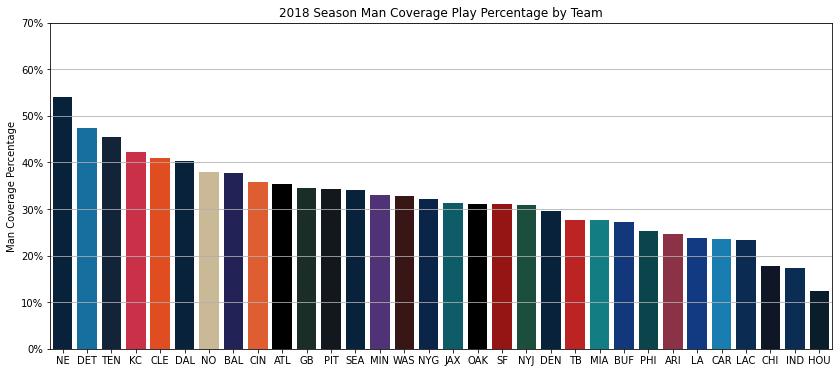

In [13]:
Image("../input/bdb-2021-figures/team_man_coverage_pct.png")

Comparing these results to 2018 coverage data provided by Sports Info Solutions (SIS) via [this tweet](https://twitter.com/keeganabdoo/status/1078722411338522624?lang=en) shows that in general, this model captures some real season-level trends:

* The model predicts New England played the most man coverage of all teams, aligning with the SIS data. Detroit, Kansas City, and Baltimore are also high-man teams. 
* Indianapolis, Los Angeles Chargers, Carolina, and Arizona are low-man (high-zone) teams.

However, the model misses on a few teams in terms of man-coverage percentage relative ranking: Dallas is far too high, Chicago and Houston are far too low. There are variations within the broad labels of man and zone coverage that this model is not capturing. 

Overall, because many season-level trends are captured with this model, the model’s man/zone predictions for each play of Weeks 2-17 supports a relative ranking analysis at a season-level.

# Normalizing for Pass Difficulty

To find individuals or specific height difference over- and under-performance, pass difficulty should be normalized so that defenders are compared against their expected performance before being compared against each other.

One outcome-based measure of pass difficulty is completion percentage. Actual completion percentage has a strong relationship with the downfield distance of the target, as shown in the figure below. To turn this relationship into a continuous function that can be evaluated for individual plays for “expected performance,” the relationship is modeled as a generalized logistic function to follow a qualitative explanation of the relationship:

* Passes behind the line of scrimmage tend to be “safe” throws (natural completion rate, asymptote)
* Increasing the distance downfield increases the difficulty (negative slope)
* As the pass attempts approach deep downfield, the difference in difficulty is small for each incremental yard (asymptote)

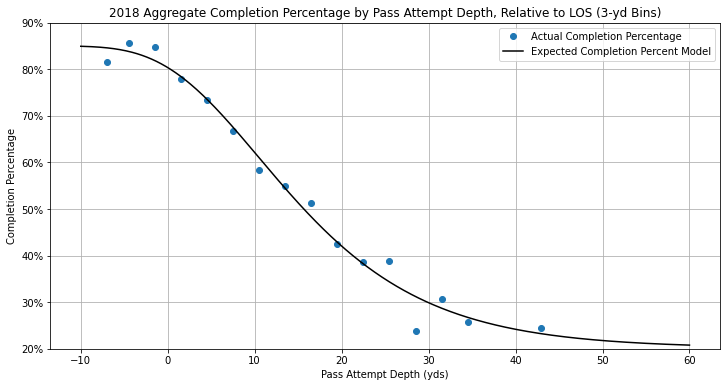

In [14]:
Image('../input/bdb-2021-figures/cmp_pct_vs_depth.png')

This simple model provides a reasonable approximation for expected completion percentage, with residuals on the order of a few completion percentage points. This level of accuracy is sufficient to answer the driving comparison questions.

## Completion Percentage Below Expected (CPBE)

The targeted defender on any given play is identified as the closest defender to the target at the time the ball arrives. Once aggregated, comparing a defender’s completion percentage against their expected completion percentage gives a normalized measure of over- or under-performance. This report defines a “Completion Percentage Below Expected” (CPBE) metric as the expected completion percentage (mean) minus the actual completion percentage:

$CPBE = \frac{\sum_{i=1}^{N_{plays}} CP_{expected,i}}{N_{plays}} -CP_{actual}$

where:

$CP_{expected,i}$ = Expected completion percentage for the $i$th play where the defender is targeted

$N_{plays}$ = Number of plays the defender is targeted

$CP_{actual}$ = Actual completion percentage (completions/targets)

Positive CPBE values mean the defender allowed a lower completion percentage than expected, which is good for the defensive team.


# Question 1: When targeted, which players excel at defending the pass in man and zone coverage?

All plays during the 2018 season are grouped by targeted defender and defensive man or zone coverage scheme. CPBE is calculated in each subset (with a minimum of 20 targets in man/zone each) and plotted for CB- and DB-listed players in the figure below. The above-average players are in the top right quadrant of the plot.

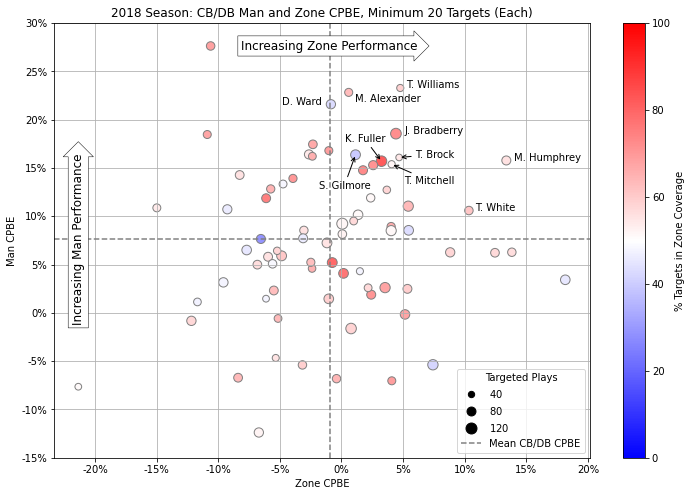

In [15]:
Image('../input/bdb-2021-figures/cb_cpbe_compare.png')

Larger markers represent more targets which implies less uncertainty of the CPBE values. Deeper blue means a higher percentage of targets when the defense plays man, while deeper red means a higher percentage of targets when the defense plays zone. The top 10 over-performing players in terms of standardized distance from the average man/zone CPBE origin are labeled. A few interesting insights from the plot:

* **Marlon Humphrey** ranked highest in terms of standardized distance from the origin and shows well above average performance in both man and zone, with a balanced coverage type ratio. This result implying elite performance is consistent with traditional metrics like pass deflections and interceptions because his 2018 stats  are nearly identical to his All-Pro 2019 season ([15/2 and 14/3, respectively](https://www.nfl.com/players/marlon-humphrey/stats/)) 
* **Denzel Ward** and **Stephon Gilmore** rank high in man coverage CPBE while being targeted mostly in man, which adds more certainty to their ranking.
* **Tramon Williams**, **Tramaine Brock**, and **Terrance Mitchell** are all in the upper quadrant but have small sample sizes. Their high performance has more uncertainty than the others mentioned earlier due to their lack of targets.

Filtering the players in the top-performing quadrant for negative average EPA in both man and zone coverage, only four CB/DB remain:

* **Marlon Humphrey**
* **Jalen Ramsey**
* **Stephon Gilmore**
* **Mackensie Alexander**

This type of analysis is useful for identifying strengths and weaknesses of individual players and could be used to refine game plans and inform roster decisions. The short analysis above uses the CB and DB positions as an example, but it is easily extensible to safeties and linebackers. The analysis could also be further refined to look at defending against specific offensive positions (RB, TE, WR, etc.).

# Question 2: Does the height difference between a receiver and defender influence defensive performance?

Instead of grouping by player, the player measurement data is merged with the target/defender per play data to group by height disparity. The average EPA for each height disparity and man/zone coverage is shown in the figure below. The distribution of height disparity (not shown) is normal-like with a mode of 2 inches, so values for larger disparities contain more uncertainty.

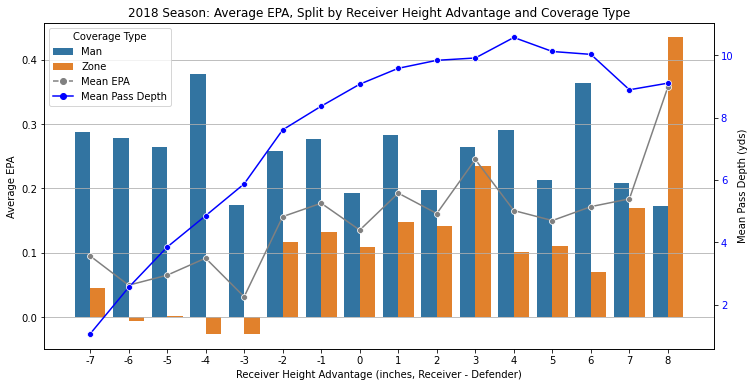

In [16]:
Image('../input/bdb-2021-figures/hgt_adv_epa.png')

In general, the mean EPA increases as the receiver increases in height relative to the defender, however this may be influenced by the distribution of passes present in each grouping; the average pass is further downfield as the receiver height advantage increases.

The comparison of CPBE vs. height difference is shown below.

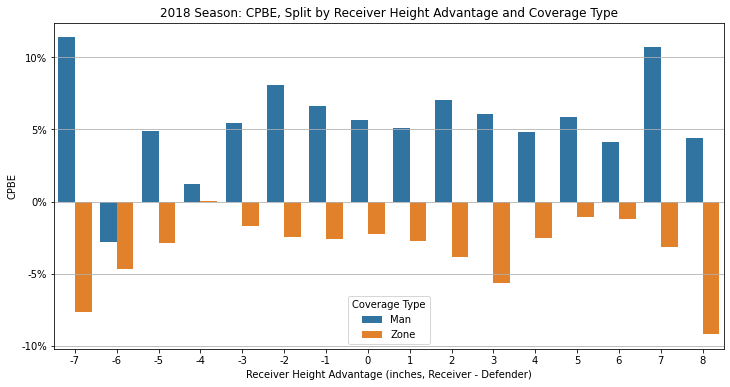

In [17]:
Image('../input/bdb-2021-figures/hgt_adv_cpbe.png')

There does not appear to be a meaningful trend for CPBE vs. height disparity. This comparison was also computed for different defense positions, offense positions, and defender-receiver position combinations with the same end conclusion (not shown). Based on the data, it appears that **height difference alone is not a significant indicator of pass defense performance.**


# Conclusions

* **Answer to Question 1:** Completion Percentage Below Expected (CPBE) provides a simple but useful comparative metric of individual defender performance and can be extended to different position groups as well. When looking at CPBE and EPA in both man and zone coverage schemes, there were 4 CB/DB in 2018 that are above average in CPBE and negative EPA in both man and zone coverage (shown below): 

    * Marlon Humphrey
    * Jalen Ramsey
    * Stephon Gilmore
    * Mackensie Alexander
    
* **Answer to Question 2:** On its own, the receiver-defender height disparity has no noticeable correlation with defensive performance for the 2018 season data. This conclusion does not change when stratifying by man and zone coverage schemes or looking at different defender-receiver position combinations.

**Other Conclusions:**

* With 7 features and a simple linear SVC model, defensive man and zone coverage schemes can be predicted with reasonable accuracy for labeling within an aggregate analysis (84%).
* The downfield distance of a pass has a strong relationship with the observed completion percentage.

## Future Work

* Building a stronger predictive model for Expected Completion Percentage will make the CPBE values useful as a standalone performance metric beyond the comparative analysis in this report.
* Building stronger and more granular classifier for specific coverage schemes (Cover 1 Man, Cover 3 Zone, etc.) could be used to identify strengths and weaknesses at an individual and team level.
* Discovering the holy grail of defending Aaron Rodgers, because the past decade has shown that no amount of scheming, manpower, or analytics puts a dent in his passing performance. (*GO PACK GO!*)


# Appendix (Code)

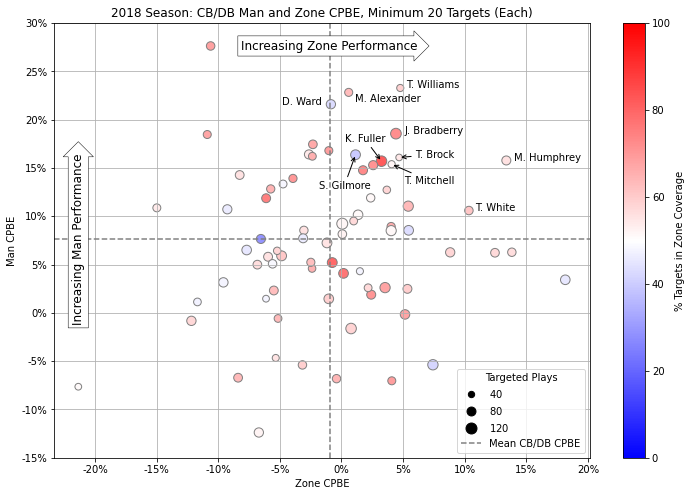

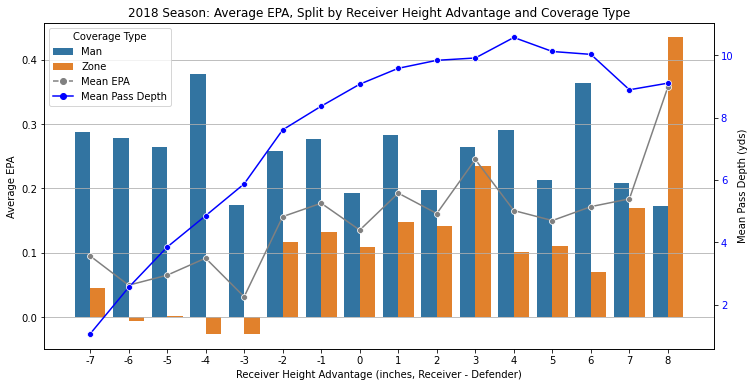

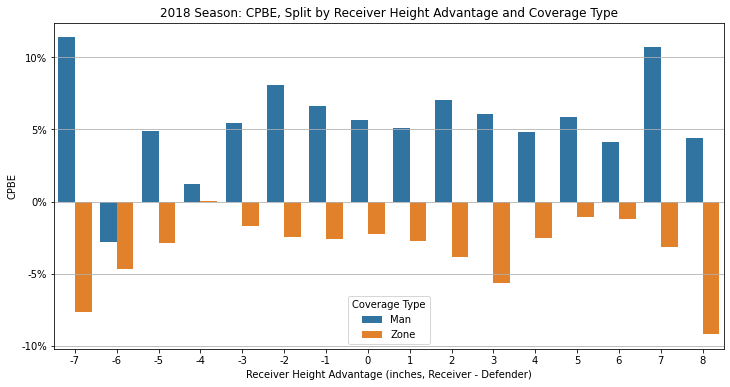

In [5]:
### ======== NFL Analysis utility functions and constants ==================== ###
import pandas as pd
import numpy as np

def _rgb(r, g, b):
    # Converts RGB range from 0-255 to 0-1 for matplotlib.
    # Returns np.array of length 3.
    return np.array([r, g, b]) / 255.0

# --------- CONSTANTS --------------------------- ####

FIELD_SIZE_X = 120.0  # yards, field goal to field goal (back of endzones)
FIELD_SIZE_Y = 53.3  # yards, sideline to sideline
TEAM_COLORS = {'ARI': {'main': _rgb(155, 35, 63), 'secondary': _rgb(255, 255, 255)},
               'ATL': {'main': _rgb(0, 0, 0), 'secondary': _rgb(255, 255, 255)},
               'BAL': {'main': _rgb(26, 25, 95), 'secondary': _rgb(255, 255, 255)},
               'BUF': {'main': _rgb(0, 51, 141), 'secondary': _rgb(198, 12, 48)},
               'CAR': {'main': _rgb(0, 133, 202), 'secondary': _rgb(16, 24, 32)},
               'CHI': {'main': _rgb(11, 22, 42), 'secondary': _rgb(200, 56, 3)},
               'CIN': {'main': _rgb(251, 79, 20), 'secondary': _rgb(255, 255, 255)},
               'CLE': {'main': _rgb(255, 60, 0), 'secondary': _rgb(49, 29, 0)},
               'DAL': {'main': _rgb(0, 34, 68), 'secondary': _rgb(134, 147, 151)},
               'DEN': {'main': _rgb(0, 34, 68), 'secondary': _rgb(251, 79, 20)},
               'DET': {'main': _rgb(0, 118, 182), 'secondary': _rgb(176, 183, 188)},
               'GB': {'main': _rgb(24, 48, 40), 'secondary': _rgb(255, 184, 28)},
               'HOU': {'main': _rgb(3, 32, 47), 'secondary': _rgb(167, 25, 48)},
               'IND': {'main': _rgb(0, 44, 95), 'secondary': _rgb(162, 170, 173)},
               'JAX': {'main': _rgb(0, 103, 120), 'secondary': _rgb(16, 24, 32)},
               'KC': {'main': _rgb(227, 24, 55), 'secondary': _rgb(255, 255, 255)},
               'LA': {'main': _rgb(0, 53, 148), 'secondary': _rgb(255, 209, 0)},
               'LAC': {'main': _rgb(0, 42, 94), 'secondary': _rgb(255, 194, 14)},
               'MIA': {'main': _rgb(0, 142, 151), 'secondary': _rgb(252, 76, 2)},
               'MIN': {'main': _rgb(79, 38, 131), 'secondary': _rgb(255, 255, 255)},
               'NE': {'main': _rgb(0, 34, 68), 'secondary': _rgb(176, 183, 188)},
               'NO': {'main': _rgb(211, 188, 141), 'secondary': _rgb(16, 24, 31)},
               'NYG': {'main': _rgb(1, 35, 82), 'secondary': _rgb(163, 13, 45)},
               'NYJ': {'main': _rgb(18, 87, 64), 'secondary': _rgb(255, 255, 255)},
               'OAK': {'main': _rgb(0, 0, 0), 'secondary': _rgb(165, 172, 175)},
               'PHI': {'main': _rgb(0, 76, 84), 'secondary': _rgb(165, 172, 175)},
               'PIT': {'main': _rgb(16, 24, 32), 'secondary': _rgb(255, 182, 18)},
               'SEA': {'main': _rgb(0, 34, 68), 'secondary': _rgb(105, 190, 40)},
               'SF': {'main': _rgb(170, 0, 0), 'secondary': _rgb(173, 153, 93)},
               'TB': {'main': _rgb(213, 10, 10), 'secondary': _rgb(10, 10, 8)},
               'TEN': {'main': _rgb(12, 35, 64), 'secondary': _rgb(75, 146, 219)},
               'WAS': {'main': _rgb(63, 16, 16), 'secondary': _rgb(255, 182, 18)}}


# -------------- FUNCTIONS -------------------------------------------

def transform_tracking_data(track_df, inplace=False):
    """
    Standardizes the tracking data so that all offensive plays have the same reference frame (Madden camera)

    Transforms all positional attributes: x, y, o, dir. Returns a copy of the dataframe. Increasing x is downfield for
    the offense, increasing y is towards the left sideline
    :param track_df: [DataFrame] tracking data
    :param inplace: [boolean] determine if transformation should be made in place or on a copy of the DataFrame
    :return: DataFrame if inplace=False, otherwise None
    """
    if inplace:
        out_df = track_df  # work on actual DataFrame
    else:
        out_df = track_df.copy()  # only apply changes to a copy of the DataFrame

    # get indexing for plays moving to the left (right is the standard)
    i_left = (out_df.playDirection == 'left')

    # transform X, Y
    out_df.loc[i_left, 'x'] = FIELD_SIZE_X - out_df.loc[i_left, 'x']
    out_df.loc[i_left, 'y'] = FIELD_SIZE_Y - out_df.loc[i_left, 'y']

    # convert the orientations so that 0 points to left sideline
    # - see figure here for more info (https://www.kaggle.com/c/nfl-big-data-bowl-2021/data)
    out_df.loc[i_left, 'o'] = (out_df.loc[i_left, 'o'] + 180) % 360
    out_df.loc[i_left, 'dir'] = (out_df.loc[i_left, 'dir'] + 180) % 360

    if inplace:
        return None  # modified inplace
    else:
        return out_df


### ==== Feature generation, model training/evaluation, model validation ================= ###

# standard imports
import pandas as pd
import numpy as np
import os.path

# model training imports
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report


# --- FEATURE GENERATION FUNCTIONS ----------------------------------------------

def create_play_features(play_track_df, game_df, play_df, t_defender_thresh=1.5, t_scheme_develop=4, t_reaction_time=0):
    ### THE INPUT TRACKING DATA MUST BE NORMALIZED FOR DIRECTION BEFORE INPUT INTO THIS FUNCTION
    # inputs:
    #     - play_track_df: DataFrame of the raw player tracking data for an individual play.
    #                      MUST ONLY BE FOR A SINGLE PLAY, CANNOT HANDLE MULTIPLE PLAYS.
    #     - game_df: DataFrame for the game data (games.csv)
    #     - play_df: DataFrame for the play data (play.csv)
    #     - t_defender_thresh: time in seconds after the snap to determine which players are in coverage
    #     - t_scheme_develop: time in seconds after the snap to set as a max time threshold
    #                         (i.e. before the play breaks down, after which the movement
    #                          is not always indicative of the coverage scheme)
    #     - t_reaction_time: time in seconds after the ball thrown to continue taking statistics (paths
    #                        won't change until players realize the ball has been thrown)

    # local constants
    DEF_DEEP_THRESH = 10  # yards behind the line of scrimmage considered "deep" coverage

    # work on a copy of the data rather than the actual data (for temporary features), drop duplicate rows
    play_track_df = play_track_df.copy().drop_duplicates()

    # get the current play gameId and playId
    game_id = play_track_df.gameId.iloc[0]
    play_id = play_track_df.playId.iloc[0]

    # determine who has the ball (team code)
    home_abbr = game_df[game_df.gameId == game_id].iloc[0]['homeTeamAbbr']

    abbr_possess = play_df[(play_df.gameId == game_id) & (play_df.playId == play_id)].iloc[0]['possessionTeam']

    if abbr_possess == home_abbr:
        team_poss = 'home'
        team_def = 'away'
    else:
        team_poss = 'away'
        team_def = 'home'

    # ------------- FEATURE GENERATION SETUP/INTERMEDIATE CALCULATIONS ----------------------

    # get play information
    x_los = play_track_df.x[(play_track_df.team == 'football') & (play_track_df.frameId == 1)].iloc[0]

    # save the distance downfield of all observations relative to the line of scrimmage
    play_track_df['depth'] = play_track_df['x'] - x_los

    # get frameId for specific points in the play (exclude handoff: not a material pivot part of the play,
    # also sometimes occurs prior to the snap)
    pivot_events = ['pass_forward', 'qb_sack', 'fumble', 'qb_strip_sack', 'pass_shovel']

    frame_max = play_track_df.frameId.max()
    frame_snap = play_track_df[play_track_df.event == 'ball_snap']['frameId'].iloc[0]
    if np.any(play_track_df.event.isin(pivot_events)):
        # find the frameId of the earliest of the pivot events
        # - account for errors on individual players: group by event, find the median frame for each event, then
        #   take the minimum of the medians to get the first event (essentially voting then min)
        frame_pivot = (play_track_df.loc[play_track_df.event.isin(pivot_events), ['event', 'frameId']]
                       .groupby('event').median().min().iloc[0]
                       + int(round(10 * t_reaction_time)))
    else:
        frame_pivot = frame_max

    # save important frameId's in the play:
    frame_start = frame_snap
    frame_cover_freeze = min(frame_max, frame_pivot, int(round(frame_snap + 10 * t_defender_thresh)))
    frame_scheme_develop = int(frame_snap + round(10 * t_scheme_develop))
    frame_end = min(frame_pivot, frame_scheme_develop, frame_max)

    # filter out data from frames outside of the range (frame_start <= F <= frame_end)
    play_track_df = play_track_df[(play_track_df.frameId >= frame_start) & (play_track_df.frameId <= frame_end)]

    # ----- SAVE SLICES OF DATAFRAME FOR DEFENDERS AND COVERAGE AND ELIGIBLE RECEIVERS ----

    ### get defensive player tracks that are in coverage (i.e. not blitzing/rushing the passer)
    cover_players = play_track_df.nflId[(play_track_df.frameId == frame_cover_freeze) &
                                        (play_track_df.team == team_def) &
                                        (play_track_df.depth > 0)]
    def_track = play_track_df[play_track_df.nflId.isin(cover_players)].pivot(
        index='frameId', columns='nflId', values=['x', 'depth', 'y', 's', 'a', 'dir', 'o'])

    ### get offensive player tracks of eligible receivers (minus QB)
    # all players
    off_track = play_track_df[(play_track_df.team == team_poss) & (play_track_df.position != 'QB')].pivot(
        index='frameId', columns='nflId', values=['x', 'depth', 'y', 's', 'a', 'dir', 'o'])

    # players downfield (depth > 0)
    downfield_players = play_track_df.nflId[(play_track_df.frameId == frame_cover_freeze) &
                                            (play_track_df.team == team_poss) &
                                            (play_track_df.depth > 0)]
    # edge case where there are no downfield receivers at the time of throw: quick screen,
    # goal-line, etc. --> classify all offensive players as "downfield"
    if len(downfield_players) == 0:
        downfield_players = play_track_df.nflId[(play_track_df.frameId == frame_cover_freeze) &
                                                (play_track_df.team == team_poss) &
                                                (play_track_df.position != 'QB')]

    downfield_track = play_track_df[play_track_df.nflId.isin(downfield_players)].pivot(
        index='frameId', columns='nflId', values=['x', 'depth', 'y', 's', 'a', 'dir', 'o'])

    # ----- OUTERMOST OFF-DEF MATCHUP FEATURES --------------------------------------------------------

    # get attributes for the outermost receivers and defenders at the snap to identify
    # coverage as inside or outside technique

    # identify outermost defenders at snap (get corresponding array column index)
    min_def_y_idx = play_track_df.loc[(play_track_df.frameId == frame_snap) &
                                      (play_track_df.team == team_def), 'y'].idxmin()
    max_def_y_idx = play_track_df.loc[(play_track_df.frameId == frame_snap) &
                                      (play_track_df.team == team_def), 'y'].idxmax()
    right_def_nfl_id = play_track_df.nflId.loc[min_def_y_idx]
    left_def_nfl_id = play_track_df.nflId.loc[max_def_y_idx]

    # get outermost defender at snap Y-coordinates during the play
    outer_def_y = np.hstack([play_track_df.y[play_track_df.nflId == left_def_nfl_id].to_numpy().reshape(-1, 1),
                             play_track_df.y[play_track_df.nflId == right_def_nfl_id].to_numpy().reshape(-1, 1)])

    # identify outermost receivers at snap (get corresponding array column index)
    min_off_y_idx = play_track_df.loc[(play_track_df.frameId == frame_snap) &
                                      (play_track_df.team == team_poss), 'y'].idxmin()
    max_off_y_idx = play_track_df.loc[(play_track_df.frameId == frame_snap) &
                                      (play_track_df.team == team_poss), 'y'].idxmax()
    right_off_nfl_id = play_track_df.nflId.loc[min_off_y_idx]
    left_off_nfl_id = play_track_df.nflId.loc[max_off_y_idx]

    # get outermost receiver at snap Y-coordinates during the play
    outer_off_y = np.hstack([play_track_df.y[play_track_df.nflId == left_off_nfl_id].to_numpy().reshape(-1, 1),
                             play_track_df.y[play_track_df.nflId == right_off_nfl_id].to_numpy().reshape(-1, 1)])

    # -- Determine if the defender shadows outside or inside of the outer receiver:
    # -- inner likely man, outer likely zone. look at snap and aggregate until throw

    # distance from the middle of the field
    dist_def_mid = np.abs(53.3 / 2 - outer_def_y)
    dist_off_mid = np.abs(53.3 / 2 - outer_off_y)
    # def - off: positive if defender is outside, negative if defender is inside
    dist_shadow_out = dist_def_mid - dist_off_mid

    # aggregate over play (mean offset inside or outside)
    dist_shadow_out_play = np.nanmean(dist_shadow_out, axis=0)

    # ------ PLAY CHARACTERISTICS AT SPECIFIC FRAMES/POINTS IN TIME -----------------------

    # find characteristics of scheme at the snap (line of scrimmage naturally divides offense + defense)
    cb_id = play_track_df[play_track_df.position == 'CB']['nflId'].unique()
    n_cb = len(cb_id)

    if n_cb > 0:
        # depth at snap
        cb_depth_at_snap = play_track_df.loc[(play_track_df.frameId == frame_start)
                                             & (play_track_df.nflId.isin(cb_id)), 'depth']

    # find characteristics of players in coverage at the "cover freeze time"
    n_deep_freeze = np.sum((play_track_df.nflId.isin(cover_players)) &
                           (play_track_df.depth >= DEF_DEEP_THRESH) &
                           (play_track_df.frameId == frame_cover_freeze))

    # ------GENERATE FEATURES FOR EACH COVERAGE PLAYER AT EACH FRAME ---------------------

    feature_data = {'depth_play_mean': [],
                    'speed_play_var': [],
                    'dist_cover_play_mean': [],
                    }

    # data that is not dependent on the specific player
    x_off = off_track['x'].to_numpy()  # (n_frame, n_off) array
    y_off = off_track['y'].to_numpy()  # (n_frame, n_off) array
    x_def_full = def_track['x'].to_numpy()  # (n_frame, n_def) array
    y_def_full = def_track['y'].to_numpy()  # (n_frame, n_def) array

    ### --- loop over each cover player (defense) ---------------------------------------
    for i, player in enumerate(cover_players):
        x_player = def_track['x'][player].to_numpy().reshape(-1, 1)  # (n_frame,1) array
        depth_player = def_track['depth'][player].to_numpy().reshape(-1, 1)  # (n_frame,1) array
        y_player = def_track['y'][player].to_numpy().reshape(-1, 1)  # (n_frame,1) array
        s_player = def_track['s'][player].to_numpy().reshape(-1, 1)  # (n_frame,1) array

        # calculate distance to each player at each time
        dist_off = np.sqrt((x_player - x_off) ** 2 + (y_player - y_off) ** 2)  # (n_frame, n_off) array
        dist_off_min = np.nanmin(dist_off, axis=1)  # (n_frame,) array

        # save average distance
        feature_data['depth_play_mean'].append(np.nanmean(depth_player))
        feature_data['speed_play_var'].append(np.nanvar(s_player))
        feature_data['dist_cover_play_mean'].append(np.nanmean(dist_off_min))

    # put results into a dataframe
    def_df = pd.DataFrame(feature_data, index=cover_players)

    ### -- loop over each downfield offensive player  (offense) ----------------------
    downfield_data = {
        'rec_space_play_mean': [],
    }

    for i, player in enumerate(downfield_players):
        # extract location of player and put as column vector
        x_player = downfield_track['x'][player].to_numpy().reshape(-1, 1)  # (n_frame,1) array
        y_player = downfield_track['y'][player].to_numpy().reshape(-1, 1)  # (n_frame,1) array

        # calculate distance to each defensive at each time
        dist_to_defender = np.sqrt(
            (x_player - x_def_full) ** 2 + (y_player - y_def_full) ** 2)  # (n_frame, n_def) array
        # get distance to closest defender
        dist_to_defender_min = np.nanmin(dist_to_defender, axis=1)  # (n_frame,) array

        # save average of distance to closest defender
        downfield_data['rec_space_play_mean'].append(np.nanmean(dist_to_defender_min))

    # put results into a dataframe
    downfield_df = pd.DataFrame(downfield_data, index=downfield_players)

    # ----------- COLLECT ALL FEATURES INTO OUTPUT SERIES -------------------------

    # return averages of features generated from applicable players, for play-level feature
    out_data = pd.concat([def_df.mean(), downfield_df.mean()])

    # add in number of deep defenders at the "freeze frame"
    out_data['n_deep_frz'] = n_deep_freeze

    # add in inside-outside technique feature
    out_data['dist_shadow_out_play_mean'] = np.mean(dist_shadow_out_play)

    # add in CB-specific feature (depth at snap of all cornerbacks)
    if n_cb > 0:
        out_data['cb_depth_snap_min'] = np.nanmin(cb_depth_at_snap)
    else:
        out_data['cb_depth_snap_min'] = 0

    return out_data


def create_feature_dataframe(track_df, coverage_df, game_df, play_df, t_scheme_develop=4, t_reaction_time=0):
    # Transform the raw tracking data so that all offensive plays face the same direction,
    # group the tracking data for each play together
    test_df_group = transform_tracking_data(track_df).groupby(['gameId', 'playId'])

    # ------ Create the features for each play ---------------------
    feature_df = pd.DataFrame()

    col_names = []
    values = []

    # loop over each play
    for (loop_game_id, loop_play_id), loop_track_df in test_df_group:

        # error block for easier debugging if a particular play runs into an error
        try:
            features = create_play_features(loop_track_df,
                                            game_df,
                                            play_df,
                                            t_scheme_develop=t_scheme_develop,
                                            t_reaction_time=t_reaction_time)
        except Exception as err:
            print(f'error in gameId {loop_game_id}, playId {loop_play_id}')
            raise err

        # first loop: save the output dataframe column names (gameId, playId, all feature names)
        if not col_names:  # empty
            col_names.extend(['gameId', 'playId'])
            col_names.extend(features.index.tolist())

        # save the gameId, playId, and all feature values into a list
        loop_values = [loop_game_id, loop_play_id]
        loop_values.extend(features.values.tolist())
        values.append(loop_values)

    # convert the features into a dataframe (1 row per play), inner join on plays with labeled coverages
    feature_df = pd.DataFrame(values, columns=col_names)
    labeled_play_df = pd.merge(feature_df, coverage_df.dropna(), on=['gameId', 'playId'])

    # split coverage into "Cover X" and Zone labels

    # Zone
    labeled_play_df['zone'] = 0
    labeled_play_df.loc[labeled_play_df.coverage.str.contains('Zone'), 'zone'] = 1

    # Cover X (Prevent will be listed as np.nan)
    labeled_play_df['cover'] = np.nan
    labeled_play_df.loc[labeled_play_df.coverage.str.contains('Cover'), 'cover'] = (
        labeled_play_df.loc[labeled_play_df.coverage.str.contains('Cover'), 'coverage'].apply(
            lambda x: int(x.split()[1]))
    )

    # return the feature dataframe
    return labeled_play_df


### SCRIPT TO GENERATE FEATURES AND TRAIN MODEL --------------------------------------------

### --- load data --------
bdb_base_path = '/kaggle/input/nfl-big-data-bowl-2021/'
bdb_bonus_path = '/kaggle/input/nfl-big-data-bowl-2021-bonus'
track_df = pd.read_csv(os.path.join(bdb_base_path, 'week1.csv'))
play_df = pd.read_csv(os.path.join(bdb_base_path, 'plays.csv'))
game_df = pd.read_csv(os.path.join(bdb_base_path, 'games.csv'))
coverage_df = pd.read_csv(os.path.join(bdb_bonus_path, 'coverages_week1.csv'))

# create features
labeled_play_df = create_feature_dataframe(track_df, coverage_df, game_df, play_df)

# drop the Prevent Zone play (for training only, final model correctly predicts Prevent as zone)
zone_df = labeled_play_df[labeled_play_df.coverage != 'Prevent Zone'].copy()

# train test split
y = zone_df.zone
X = zone_df.drop(columns=['gameId', 'playId', 'coverage', 'zone', 'cover'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123456)

### TRAIN MODEL
### -- After many side studies, SVC always performed the best at avoiding overfitting without sacrificing accuracy.
###    Other algorithms investigated were Random Forest, AdaBoost, Naive Bayes, and KNN. PCA was also investigated
###    as a feature down-selection method, but did not have a meaningful impact on results.

# build pipeline
estimators_svc = [('normalize', StandardScaler()),
              ('clf', SVC())]
pipe_svc = Pipeline(estimators_svc)

# build grid search
param_grid_svc = [
    {
        'clf': [LinearSVC(random_state=123456)],
        'clf__class_weight': [None, 'balanced']
    },
    {
        'clf': [SVC(random_state=123456)],
        'clf__kernel': ['poly', 'rbf', 'sigmoid'],
        'clf__gamma': ['scale', 'auto'],
        'clf__class_weight': [None, 'balanced']
}]

# train model
clf_zone = GridSearchCV(pipe_svc, param_grid=param_grid_svc, return_train_score=True)
clf_zone.fit(X_train, y_train)
print(f'Best model and parameters: {clf_zone.best_params_}')
print(f'Train accuracy: {clf_zone.cv_results_["mean_train_score"][clf_zone.best_index_]:.3f}')
print(f'CV test accuracy: {clf_zone.cv_results_["mean_test_score"][clf_zone.best_index_]:.3f}')

# evaluate on holdout set
y_pred = clf_zone.predict(X_test)
print(f'Test accuracy: {accuracy_score(y_test, y_pred):.3f}')
print(f'Test f1: {f1_score(y_test, y_pred):.3f}')
print()
print('Classification Report:')
print(classification_report(y_test, y_pred))
print()
print('Confusion Matrix: ')
print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                   index=['Actual Man', 'Actual Zone'],
                   columns=['Pred. Man', 'Pred. Zone']))
print()

### - END SCRIPT ---------------------------------------------------------------------------

## === Analysis ============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as optim


# --- Functions --------------------------------------------------------------------------------------------------
def closest_defender(track_df, game_df, play_df, target_df):
    # returns the nflId of the defensive player closest to the targeted player at the resolution of the pass attempt
    #
    # inputs:
    #     - track_df: DataFrame of the raw player tracking data for an individual play.
    #                      MUST ONLY BE FOR A SINGLE PLAY, CANNOT HANDLE MULTIPLE PLAYS.
    #     - game_df: DataFrame for the game data (games.csv)
    #     - play_df: DataFrame for the play data (play.csv)

    # initialize output series
    cd_series = pd.Series([np.nan, np.nan], index=['nflId_def', 'dist_def'])

    # add target as a column of the tracking DataFrame
    play_track_df = pd.merge(track_df, target_df, how='left', on=['gameId', 'playId'])

    # get the current play gameId and playId
    game_id = play_track_df.gameId.iloc[0]
    play_id = play_track_df.playId.iloc[0]

    # determine who has the ball (team code)
    home_abbr = game_df[game_df.gameId == game_id].iloc[0]['homeTeamAbbr']

    abbr_possess = play_df[(play_df.gameId == game_id) & (play_df.playId == play_id)].iloc[0]['possessionTeam']

    if abbr_possess == home_abbr:
        team_def = 'away'
    else:
        team_def = 'home'

    if np.any(play_track_df.targetNflId.isna()):
        # no targeted receiver data for this play, return NaN
        return cd_series

    # constants
    PASS_END_EVENTS = ['pass_arrived',
                       'pass_outcome_interception',
                       'pass_outcome_incomplete',
                       'pass_outcome_caught']
    # find the frameId of the earliest of the pass end events
    # - account for errors on individual players: group by event, find the median frame for each event, then
    #   take the minimum of the medians to get the first event (essentially voting then min)
    frame_id = (play_track_df.loc[play_track_df.event.isin(PASS_END_EVENTS), ['event', 'frameId']]
        .groupby('event').median().min().iloc[0])
    if np.isnan(frame_id):
        return cd_series  # no frame to choose closest defender, return nan

    # get the data of the applicable frame
    frame_df = play_track_df[play_track_df.frameId == frame_id]

    # get the location of the targeted receiver
    if not np.any(frame_df.nflId == frame_df.targetNflId):
        # no target data for the play, discard
        return cd_series

    # QB throwaways consider the target the QB. If this is the case, do not consider closest defender.
    tgt_position = frame_df.loc[frame_df.nflId == frame_df.targetNflId, 'position'].iloc[0]
    if tgt_position == 'QB':
        return cd_series

    x_tgt = frame_df.loc[frame_df.nflId == frame_df.targetNflId, 'x'].iloc[0]
    y_tgt = frame_df.loc[frame_df.nflId == frame_df.targetNflId, 'y'].iloc[0]

    # get the location of defenders
    if not np.any(frame_df.team == team_def):
        # no defender data - return nan
        return cd_series

    nfl_id_def = frame_df.loc[frame_df.team == team_def, 'nflId'].to_numpy()
    x_def = frame_df.loc[frame_df.team == team_def, 'x'].to_numpy()
    y_def = frame_df.loc[frame_df.team == team_def, 'y'].to_numpy()

    # calculate the distance between the defenders and the targeted receiver
    dist_def = np.sqrt((x_def - x_tgt) ** 2 + (y_def - y_tgt) ** 2)

    # determine the closest defender to the ball
    idx_min = np.argmin(dist_def)

    # return ID and distance for closest defender
    cd_series['nflId_def'] = nfl_id_def[idx_min]
    cd_series['dist_def'] = dist_def[idx_min]
    return cd_series


def depth_of_pass(track_df, target_df):
    # Calculates the depth of the pass attempt target past the line of scrimmage.
    #
    # inputs:
    #     - track_df: DataFrame of the raw player tracking data for an individual play.
    #                      MUST ONLY BE FOR A SINGLE PLAY, CANNOT HANDLE MULTIPLE PLAYS.
    #     - target_df: DataFrame of the pass attempt targets per play (targetedReceiver.csv)

    # transform the directionality of the data, add targeted receiver as a column
    play_track_df = pd.merge(transform_tracking_data(track_df), target_df,
                             how='left', on=['gameId', 'playId'])

    if np.any(play_track_df.targetNflId.isna()):
        # no targeted receiver data for this play, return NaN
        return np.nan

    # constants
    PASS_END_EVENTS = ['pass_arrived',
                       'pass_outcome_interception',
                       'pass_outcome_incomplete',
                       'pass_outcome_caught']
    # find the frameId of the earliest of the pass end events
    # - account for errors on individual players: group by event, find the median frame for each event, then
    #   take the minimum of the medians to get the first event (essentially voting then min)
    frame_id = (play_track_df.loc[play_track_df.event.isin(PASS_END_EVENTS), ['event', 'frameId']]
        .groupby('event')
        .median().min().iloc[0])

    if np.isnan(frame_id):
        return np.nan  # no frame to choose closest defender, return nan

    # get the data of the applicable frame
    frame_df = play_track_df[play_track_df.frameId == frame_id].copy()

    # get the location of the targeted receiver
    if not np.any(frame_df.nflId == frame_df.targetNflId):
        # no target data for the play, discard
        return np.nan

    # QB throwaways consider the target the QB. If this is the case, do not consider closest defender.
    tgt_position = frame_df.loc[frame_df.nflId == frame_df.targetNflId, 'position'].iloc[0]
    if tgt_position == 'QB':
        return np.nan

    # get x-coordinate of the line of scrimmage (in normalized direction)
    x_los = play_track_df.x[(play_track_df.team == 'football') & (play_track_df.frameId == 1)].iloc[0]

    # save the distance downfield of all observations relative to the line of scrimmage
    frame_df['depth'] = frame_df['x'] - x_los

    depth_tgt = frame_df.loc[frame_df.nflId == frame_df.targetNflId, 'depth'].iloc[0]

    # return the depth of the target
    return depth_tgt


def create_zone_predict_dataframe(clf_zone, track_df, game_df, play_df,
                                  t_scheme_develop=4, t_reaction_time=0,
                                  coverage_df=None, bad_plays=None):
    # Creates the dataframe of features and zone predictions
    #
    # inputs:
    #   - clf_zone: scikit-learn model for predicting man/zone
    #   - track_df: DataFrame of tracking data (full week of data, week{i}.csv)
    #   - game_df: DataFrame of game data (games.csv)
    #   - play_df: DataFrame of play data (plays.csv)
    #   - t_scheme_develop: time in seconds after the snap to set as a max time threshold
    #                         (i.e. before the play breaks down, after which the movement
    #                          is not always indicative of the coverage scheme)
    #   - t_reaction_time: time in seconds after the ball thrown to continue taking statistics (paths
    #                        won't change until players realize the ball has been thrown)
    #   - coverage_df: DataFrame of actual coverages, None if not available (only for week 1, coverages_week1.csv)
    #   - bad_plays: list of (gameId, playId) tuples to ignore in analysis

    # remove bad plays (if provided)
    if bad_plays is not None and len(bad_plays) > 0:
        track_df = track_df[~track_df[['gameId', 'playId']].apply(tuple, 1).isin(bad_plays)]

    # filter out any plays that are missing an entire team (does occur in the dataset where the defense is missing:
    # 3 is for 'home', 'away', and 'football')
    track_df = track_df.groupby(['gameId', 'playId']).filter(lambda df: len(df.team.unique()) == 3)

    # filter out spike plays
    track_df = track_df.groupby(['gameId', 'playId']).filter(lambda df: np.all(df.event != 'qb_spike'))

    # Transform the raw tracking data so that all offensive plays face the same direction,
    # group the tracking data for each play together
    test_df_group = transform_tracking_data(track_df).groupby(['gameId', 'playId'])

    # ------ Create the features for each play ---------------------
    feature_df = pd.DataFrame()

    col_names = []
    values = []

    # loop over each play
    for (loop_game_id, loop_play_id), loop_track_df in test_df_group:

        # error block for easier debugging if a particular play runs into an error
        try:
            features = create_play_features(loop_track_df,
                                            game_df,
                                            play_df,
                                            t_scheme_develop=t_scheme_develop,
                                            t_reaction_time=t_reaction_time)
        except Exception as err:
            print(f'error in gameId {loop_game_id}, playId {loop_play_id}')
            raise err

        # first loop: save the output dataframe column names (gameId, playId, all feature names)
        if not col_names:  # empty
            col_names.extend(['gameId', 'playId'])
            col_names.extend(features.index.tolist())

        # save the gameId, playId, and all feature values into a list
        loop_values = [loop_game_id, loop_play_id]
        loop_values.extend(features.values.tolist())
        values.append(loop_values)

    # convert the features into a dataframe (1 row per play), inner join on plays with labeled coverages
    feature_df = pd.DataFrame(values, columns=col_names)

    # create zone-labeled plays
    labeled_play_df = feature_df.copy()

    # make predictions
    labeled_play_df['zone'] = clf_zone.predict(feature_df.drop(columns=['gameId', 'playId']))

    # if the actual labels are known, set the plays to those values
    if coverage_df is not None:
        # classify the actual coverage as man or zone
        temp_df = coverage_df.copy()
        temp_df['zone'] = np.nan  # initialize all as nan
        temp_df.loc[temp_df.coverage.str.contains('Zone'), 'zone'] = 1
        temp_df.loc[temp_df.coverage.str.contains('Man'), 'zone'] = 0

        if np.sum(temp_df.zone.isna()) > 0:
            raise ValueError(
                'coverage_df contains a value in the "coverage" field that does not contain "Man" or "Zone"')

        # overwrite particular plays with known values
        known_coverage_idx = pd.MultiIndex.from_frame(temp_df[['gameId', 'playId']])
        labeled_play_df.set_index(['gameId', 'playId'], inplace=True)
        labeled_play_df.loc[known_coverage_idx, 'zone'] = temp_df['zone'].to_numpy()
        # set index back to original
        labeled_play_df.reset_index(inplace=True)

    # return the feature dataframe
    return labeled_play_df


def ftin_to_in(ftin):
    # converts ft-in notation to inches (i.e. 6-2 to 74)
    [f, i] = ftin.split('-')
    return 12 * int(f) + int(i)


### --- BELOW THIS LINE: SCRIPT CODE TO GENERATE FEATURES, MANIPULATE DATA, AND CREATE PLOTS ----------
# load data
bdb_base_path = '/kaggle/input/nfl-big-data-bowl-2021/'
bdb_bonus_path = '/kaggle/input/nfl-big-data-bowl-2021-bonus'
track_df = pd.read_csv(os.path.join(bdb_base_path, 'week1.csv'))
play_df = pd.read_csv(os.path.join(bdb_base_path, 'plays.csv'))
game_df = pd.read_csv(os.path.join(bdb_base_path, 'games.csv'))
player_df = pd.read_csv(os.path.join(bdb_base_path, 'players.csv'))
coverage_df = pd.read_csv(os.path.join(bdb_bonus_path, 'coverages_week1.csv'))
target_df = pd.read_csv(os.path.join(bdb_bonus_path, 'targetedReceiver.csv'))

# remove bad plays from the analysis
# 1. gameId = 2018102101, playId = 3078: Offense positions are clearly wrong at start and during play
# 2. gameId = 2018092301, playId = 477: SS Jefferson position jumps around and is intermittent during play
# 3. gameId = 2018092301, playId = 949: Same as play 477
bad_plays = [(2018102101, 3078),
             (2018092301, 477),
             (2018092301, 949)]

# --- Generate zone predictions, depth of pass, and targeted defender data for all weeks ------------------
processed_weeks = []  # list of DataFrames containing processed data
zone_predict = []  # list of DataFrames containing zone prediction data
max_week = 17

for week in range(1, max_week + 1):  # weeks 1-17
    print(f'Analyzing tracking data for week {week}...')
    # load tracking data
    temp_track_df = pd.read_csv(os.path.join(bdb_base_path, f'week{week}.csv'))
    # calculate closest defender
    closest_def = temp_track_df.groupby(['gameId', 'playId']).apply(closest_defender,
                                                                    game_df, play_df, target_df).reset_index()
    # calculate depth of pass
    dop_df = temp_track_df.groupby(['gameId', 'playId']).apply(depth_of_pass, target_df).reset_index()
    dop_df.rename(columns={0: 'pass_depth'}, inplace=True)
    # combine into single dataframe
    processed_weeks.append(pd.merge(closest_def, dop_df, on=['gameId', 'playId']))

    # predict man/zone coverage
    if week == 1:
        # use actual known labels since they are available
        zone_df = create_zone_predict_dataframe(clf_zone, temp_track_df, game_df, play_df, coverage_df=coverage_df,
                                                bad_plays=bad_plays)
    else:
        # no known coverage, predict the coverage based on the model
        zone_df = create_zone_predict_dataframe(clf_zone, temp_track_df, game_df, play_df,
                                                bad_plays=bad_plays)
    # save the data for the week
    zone_predict.append(zone_df)

print('Loop complete.')

# concatenate into a full matrix
closest_def_df = pd.concat(processed_weeks, ignore_index=True)

# remove "special"/non-traditional passing plays (fake punts, fake field goals, spikes, etc.)
closest_def_df.set_index(['gameId', 'playId'], inplace=True)
valid_plays_mi = pd.MultiIndex.from_frame(play_df.loc[play_df.typeDropback != 'UNKNOWN', ['gameId', 'playId']])
closest_def_df = closest_def_df.loc[valid_plays_mi]
closest_def_df.reset_index(inplace=True)

# concatenate zone dataframes
zone_def_df = pd.concat(zone_predict, ignore_index=True)

# ----- Build dataframe for pass play analysis ----------------------------------------------------

# create base dataframe for pass play characteristics
pass_df = pd.merge(closest_def_df, zone_def_df,
                          how='left',
                          on=['gameId','playId'])

# add targeted receiver data to the DataFrame
pass_df = pd.merge(pass_df, target_df.rename(columns={'targetNflId': 'nflId_target'}),
        how='left',
        on=['gameId','playId'])

# - Over 99.5% of the cases are below 15 yards to the closest defender. This is a reasonable cutoff for downstream
# - analysis so that prevent or soft zone (coverages designed to give up yards but not points) does not count against
# - an individual's performance, since filtering the mean defensive team depth of over 15 yards during the play has a
# - closest defender distance of under 15 yards 90% of the time as well (signifying soft coverage but not prevent).
# - Therefore removing all cases above 15 yards to the closest defender effectively filters out the vast majority of
# - prevent defense plays where there is no real attempt to force an incompletion.

# flag scenarios where the closest individual is not really attempting to cause an incompletion
dist_def_cutoff = 15
pass_df['covered'] = (pass_df.dist_def < dist_def_cutoff).astype(int)

# get the height of each player
ind_ftin = player_df.height.str.contains('-')
player_df.loc[ind_ftin, 'height'] = player_df.height[ind_ftin].apply(ftin_to_in)
player_df.loc[:, 'height'] = player_df.height.astype('int')

# add the targeted defender height
pass_df = pd.merge(pass_df, player_df[['nflId', 'height']].rename(columns={'nflId': 'nflId_def',
                                                                           'height': 'def_height'}),
                   how='left',
                   on='nflId_def'
                  )

# add the targeted receiver height
pass_df = pd.merge(pass_df, player_df[['nflId', 'height']].rename(columns={'nflId': 'nflId_target',
                                                                           'height': 'tgt_height'}),
                   how='left',
                   on='nflId_target'
                  )

# add the height difference between the receiver and defender
# 'tgt_height_adv' = target height advantage (target - defender)
pass_df['tgt_height_adv'] = pass_df.tgt_height - pass_df.def_height

# Grouping together the height advantage values <= -7 and >= 8 will group the extremes to roughly 200 pass plays
min_bin_bound = -7
max_bin_bound = 8
pass_df['tgt_height_adv_bin'] = pass_df.tgt_height_adv
pass_df.loc[pass_df.tgt_height_adv <= min_bin_bound, 'tgt_height_adv_bin'] = min_bin_bound
pass_df.loc[pass_df.tgt_height_adv >= max_bin_bound, 'tgt_height_adv_bin'] = max_bin_bound

# add in EPA and pass result information
pass_df = pd.merge(pass_df, play_df[['gameId','playId','epa', 'passResult']],
                  on=['gameId', 'playId'],
                  how='left')

# ----- Man/Zone model verification analysis by team man percentage over 2018 season ---------------------------
# get the teams involved in each play
defend_team_df = pd.merge(play_df[['gameId','playId','possessionTeam']],
                game_df[['gameId','homeTeamAbbr','visitorTeamAbbr','week']],
                on='gameId')
# get the defending team
defend_team_df['defendTeam'] = defend_team_df.apply(
    lambda x: x.homeTeamAbbr if (x.visitorTeamAbbr == x.possessionTeam) else x.visitorTeamAbbr,
    axis=1)

# only keep the gameId, playId, week, and defendTeam
defend_team_df = defend_team_df[['gameId','playId','week','defendTeam']].copy()

# add the zone label to the dataframe
defend_team_df = pd.merge(defend_team_df, pass_df[['gameId','playId','zone']], on=['gameId','playId'])

# add reciprocal label of 'zone' ('man')
defend_team_df['man'] = (defend_team_df.zone == 0).astype(int)

# calculate the man coverage percentage and sort for plotting
team_man_agg = (defend_team_df[['defendTeam','man']]
                .groupby('defendTeam')
                .mean()
                .reset_index().sort_values('man', ascending=False))
team_man_agg['man_pct'] = team_man_agg.man * 100

# get team colors into a list format
team_color_dict = {team: colordict['main'] for team, colordict in TEAM_COLORS.items()}
team_color_list = [team_color_dict[team].tolist() for team in team_man_agg.defendTeam.tolist()]

# plot man percentages for each team
f = plt.figure(figsize=(14, 6))
ax = f.gca()
plt.grid('on')
sns.barplot(data=team_man_agg, x='defendTeam', y='man_pct',
            palette=team_color_list, ci=None)
plt.ylim([0, 70])
vals = ax.get_yticks()
ax.set_yticklabels([f'{int(i)}%' for i in vals])

plt.xlabel('')
plt.ylabel('Man Coverage Percentage')
plt.title('2018 Season Man Coverage Play Percentage by Team')

plt.show()


# ------ Normalizing for Pass Difficulty -------------------------------------------

# get base DataFrame with gameId, playId, pass_depth, and passResult
comp_depth_df = pd.merge(pass_df[['gameId','playId','pass_depth']],
                         play_df[['gameId','playId','passResult']])
comp_depth_df.dropna(inplace=True)

# add flag for complete vs not complete
comp_depth_df['comp'] = (comp_depth_df.passResult=='C').astype(int)

# bin the pass depths to get aggregate completion percentages for the 2018 season
min_depth = -6  # all below this value will be binned together
max_depth = 36 # all above this value will be binned together
bin_width = 3  # yards

depth_bins = np.concatenate([np.array([-100]), np.arange(min_depth, max_depth + 0.01, bin_width), np.array([100])])
# define the depth to use for regression (middle of the bin, except for the ends which will use a cutoff)
depth_points_mid = (depth_bins[1:-2] + depth_bins[2:-1]) / 2
# first and last points are temporary
depth_points = np.concatenate([np.array([-100]), depth_points_mid, np.array([100])])
# set first and last points to the mean value for the extreme bins
depth_points[0] = comp_depth_df.loc[comp_depth_df.pass_depth <= min_depth, 'pass_depth'].mean()
depth_points[-1] = comp_depth_df.loc[comp_depth_df.pass_depth > max_depth, 'pass_depth'].mean()

# add bins to the dataframe
comp_depth_df['pass_depth_bin'] = pd.cut(comp_depth_df['pass_depth'], depth_bins)

# aggregate plays by bin
comp_depth_agg = comp_depth_df.groupby('pass_depth_bin').agg(
    comp_pct=pd.NamedAgg(column='comp', aggfunc='mean')
)

# save the midpoint of the bin (or mean for first and last bins) for plotting and curve fit
comp_depth_agg['depth_point'] = depth_points

# -- Curve fit the data with a logistic function --
def logistic_fcn(depth, a, b, k, q, v):
    # generic logistic function equation
    return a + (k - a) / ((1 + q * np.exp(-b * depth)) ** (1/v))

# initialize parameters and bounds for logistic curve fit (a,b,k,q,v)
p0 = np.array([.85, .05, .25, .25, 1])
log_bounds = ([0, 0, 0, 0, .00000000001], [1, 3, 1, 1000, 10])

x_depth = comp_depth_agg.depth_point.to_numpy()  # independent variable
y_comp_pct = comp_depth_agg.comp_pct.to_numpy()  # dependent variable
# fit data to the logistic curve
cmp_model_params, _ = optim.curve_fit(logistic_fcn, x_depth, y_comp_pct, bounds=log_bounds, p0=p0)

# create a handle to the completion percentage model
cmp_pct_model = lambda depth: logistic_fcn(depth, *cmp_model_params)

# generate the curve fit
x_curve = np.linspace(-10, 60, 500)
cmp_curve = cmp_pct_model(x_curve)

# plot the data
f = plt.figure(figsize=(10, 5))
ax = f.gca()
plt.plot(x_depth, y_comp_pct, marker='o', linestyle='')
plt.plot(x_curve, cmp_curve, linestyle='-', marker=None, color='k', label='Expected Completion Percent Model')
plt.xlabel('Pass Attempt Depth (yds)')
plt.ylabel('Completion Percentage')
plt.ylim([.2, .9])
# add percentage y-labels
vals = ax.get_yticks()
ax.set_yticklabels([f'{int(i * 100)}%' for i in vals])
plt.title(f'2018 Aggregate Completion Percentage by Pass Attempt Depth, Relative to LOS ({bin_width}-yd Bins)')
plt.legend()
plt.grid(True)
plt.show()


# ------- Analysis for Question 1 (best defenders in man/zone, CBs/DBs) ------------------------------

# base dataframe
cpbe_df = pass_df[['gameId', 'playId', 'nflId_def', 'pass_depth', 'zone', 'covered', 'passResult', 'epa']].copy().dropna()

# calculate the expected completion percentage
cpbe_df['cp_expect'] = cmp_pct_model(cpbe_df.pass_depth)

# remove the plays where there wasn't really coverage (very soft zone)
cpbe_df = cpbe_df[cpbe_df.covered == 1]

# aggregate by targeted defender: total plays, zone plays, man plays, average EPA, comp. pct., expected comp. pct.
cpbe_agg = cpbe_df.groupby('nflId_def').agg(
    plays_total = pd.NamedAgg(column='passResult', aggfunc=len),
    plays_zone = pd.NamedAgg(column='zone', aggfunc=lambda x: np.sum(x==1)),
    plays_man = pd.NamedAgg(column='zone', aggfunc=lambda x: np.sum(x==0)),
    epa_avg_tot = pd.NamedAgg(column='epa', aggfunc='mean'),
    cp_tot = pd.NamedAgg(column='passResult', aggfunc=lambda x: np.mean(x=='C')),
    cp_expect_tot = pd.NamedAgg(column='cp_expect', aggfunc='mean'),
).reset_index()

# calculate percentage of plays targeted in zone
cpbe_agg['pct_zone'] = cpbe_agg.plays_zone / cpbe_agg.plays_total

# make play count columns integers
cpbe_agg['plays_zone'] = cpbe_agg.plays_zone.astype(int)
cpbe_agg['plays_man'] = cpbe_agg.plays_man.astype(int)

# calculate CPBE
cpbe_agg['cpbe'] = cpbe_agg.cp_expect_tot - cpbe_agg.cp_tot

cpbe_agg = pd.merge(cpbe_agg, player_df[['nflId', 'displayName', 'position']],
                    left_on='nflId_def', right_on='nflId', how='left').drop(columns='nflId')

# get the average EPA, CP, and expected CP for zone vs. man coverage
man_zone_agg = cpbe_df.groupby(['nflId_def', 'zone']).agg(
    epa_avg = pd.NamedAgg(column='epa', aggfunc='mean'),
    cp_avg = pd.NamedAgg(column='passResult', aggfunc=lambda x: np.mean(x=='C')),
    cp_expect_avg = pd.NamedAgg(column='cp_expect', aggfunc='mean')
).unstack()
man_zone_agg.columns = ['epa_avg_man', 'epa_avg_zone', 'cp_man', 'cp_zone', 'cp_expect_man', 'cp_expect_zone']
man_zone_agg.reset_index(inplace=True)

# calculate CPBE
man_zone_agg['cpbe_man'] = man_zone_agg.cp_expect_man - man_zone_agg.cp_man
man_zone_agg['cpbe_zone'] = man_zone_agg.cp_expect_zone - man_zone_agg.cp_zone

# add man/zone breakdown into main CB/DB analysis dataframe
cpbe_agg = pd.merge(cpbe_agg, man_zone_agg, on='nflId_def')

# reduced dataframe to CB/DB and 20+ man, 20+ zone targets
cb_agg = cpbe_agg[cpbe_agg.position.isin(['CB', 'DB'])].copy()
cb_mz = cb_agg[(cb_agg.plays_zone >= 20) & (cb_agg.plays_man >= 20)]

# --- Question 1 plot for CB/DB CPBE man and zone -------------------------------------

# figure
f = plt.figure(figsize=(12, 8))
ax = f.gca()
plt.axhline(cb_mz.cpbe_man.mean(), ls='--', c='gray')
plt.axvline(cb_mz.cpbe_zone.mean(), ls='--', c='gray')
scatter = plt.scatter(cb_mz.cpbe_zone, cb_mz.cpbe_man,
                      c=cb_mz.pct_zone * 100,
                      s=cb_mz.plays_total,
                      marker='o',
                      edgecolors='gray',
                      cmap='bwr')
plt.grid(True)

# colorbar
plt.colorbar(label='% Targets in Zone Coverage', orientation='vertical')
plt.clim([0, 100])

# legend
sizes = [40, 80, 120]
scatter_legend = plt.scatter([None] * len(sizes), [None] * len(sizes), s=sizes, c='k')
mean_legend = plt.plot([], [], ls='--', c='gray', label='Mean CPBE')[0]
legend_elements = scatter_legend.legend_elements(prop='sizes')
legend_elements[0].append(mean_legend)
legend_elements[1].append("Mean CB/DB CPBE")
plt.legend(*legend_elements, title='Targeted Plays', loc='lower right')

# limits
ax.set_ylim([-.15, .30])

### annotations
# arrows
ax.text(cb_mz.cpbe_zone.mean(), cb_mz.cpbe_man.max(),
        "Increasing Zone Performance", ha="center", va="center", rotation=0, size=12,
        bbox=dict(boxstyle="rarrow,pad=0.3", fc="white", ec=[.05, .05, .05], lw=0.5))

ax.text(cb_mz.cpbe_zone.min(), cb_mz.cpbe_man.mean(),
        "Increasing Man Performance", ha="center", va="center", rotation=90, size=12,
        bbox=dict(boxstyle="rarrow,pad=0.3", fc="white", ec=[.05, .05, .05], lw=0.5))

# players
temp_df = cb_mz.copy()
temp_df['cpbe_dist'] = np.sqrt(((cb_mz.cpbe_zone - cb_mz.cpbe_zone.mean()) / cb_mz.cpbe_zone.std()) ** 2
                               + ((cb_mz.cpbe_man - cb_mz.cpbe_man.mean()) / cb_mz.cpbe_man.std()) ** 2)
temp_df['shortName'] = temp_df.displayName.str.split().apply(lambda x: x[0][0] + '. ' + x[1])

# get top 10 performers
temp_df = temp_df[(temp_df.cpbe_zone > temp_df.cpbe_zone.mean())
                  & (temp_df.cpbe_man > temp_df.cpbe_man.mean())].sort_values('cpbe_dist', ascending=False).head(
    10).set_index('displayName')
annot_df = pd.DataFrame({'x_offset': 0, 'y_offset': 0, 'arrowstyle': None}, index=temp_df.index)
annot_df.loc['Denzel Ward', :] = [-0.04, 0, None]
annot_df.loc['Mackensie Alexander', :] = [0.005, -0.01, None]
annot_df.loc['Tramon Williams', :] = [0.005, 0, None]
annot_df.loc['James Bradberry', :] = [0.007, 0, None]
annot_df.loc['Stephon Gilmore', :] = [-0.03, -0.035, '->']
annot_df.loc['Marlon Humphrey', :] = [0.006, 0, None]
annot_df.loc["Tre'Davious White", :] = [0.005, 0, None]
annot_df.loc['Tramaine Brock', :] = [0.013, 0, '->']
annot_df.loc['Kyle Fuller', :] = [-0.03, 0.02, '->']
annot_df.loc['Terrance Mitchell', :] = [0.01, -0.02, '->']

# add arrows to specific names
for name, row in temp_df.iterrows():
    if annot_df.loc[name].arrowstyle is not None:
        annot_kwarg = {'arrowprops': {'arrowstyle': annot_df.loc[name].arrowstyle}}
    else:
        annot_kwarg = {}

    ax.annotate(row.shortName, (row.cpbe_zone, row.cpbe_man),
                xytext=(row.cpbe_zone + annot_df.loc[name].x_offset, row.cpbe_man + annot_df.loc[name].y_offset),
                **annot_kwarg)

# make axis labels percentages
x_vals = ax.get_xticks()
ax.set_xticklabels([f'{int(round(i*100))}%' for i in x_vals])
y_vals = ax.get_yticks()
ax.set_yticklabels([f'{int(round(i*100))}%' for i in y_vals])
    
# labels and title
plt.xlabel('Zone CPBE')
plt.ylabel('Man CPBE')
plt.title('2018 Season: CB/DB Man and Zone CPBE, Minimum 20 Targets (Each)')

plt.show()


# ------- Analysis for Question 2 (height advantage impact on passing performance) -------------------

# base dataframe: merge height difference to CPBE base dataframe
height_df = pd.merge(cpbe_df.drop(columns='covered'),
                     pass_df[['gameId','playId','tgt_height_adv','tgt_height_adv_bin']],
                     how='left', on=['gameId','playId'])

# attach defender position
height_df = pd.merge(height_df, player_df[['nflId','displayName','position']].copy().rename(
                                                columns={'displayName': 'defenderName', 'position': 'defenderPos'}),
                   left_on='nflId_def', right_on='nflId', how='left').drop(columns='nflId')

# attach receiver nflId as targetNflId
height_df = pd.merge(height_df, target_df, on=['gameId','playId'], how='left')

# attach receiver position and name
height_df = pd.merge(height_df, player_df[['nflId','displayName','position']].copy().rename(
                                                columns={'displayName': 'receiverName', 'position': 'receiverPos'}),
                   left_on='targetNflId', right_on='nflId', how='left').drop(columns='nflId')

# add cpbe for each play (for seaborn)
height_df['cpbe'] = height_df.cp_expect - (height_df.passResult=='C').astype(int)

# add label to make it easier for seaborn stratification and legend
height_df['zone_label'] = 'Man'
height_df.loc[height_df.zone==1, 'zone_label'] = 'Zone'

# ------- Function to plot the Question 2 height advantage passing performance data -------
def plot_height_adv_coverage_split(height_df, target, figsize=(12, 6), rec_positions=None, def_positions=None,
                                   show_pass_depth=False):
    # create label based on target
    if target == 'epa':
        ylabel = 'Average EPA'
    elif target == 'cpbe':
        ylabel = 'CPBE'
    else:
        ylabel = target

    # filter down based on input positions
    plot_df = height_df.copy()
    if rec_positions:
        if type(rec_positions) is str:
            rp = [rec_positions]  # make it a list
        elif type(rec_positions) is list:
            rp = rec_positions
    else:  # use all positions
        rp = plot_df.receiverPos.unique().tolist()

    if def_positions:
        if type(def_positions) is str:
            dp = [def_positions]  # make it a list
        elif type(def_positions) is list:
            dp = def_positions
    else:  # use all positions
        dp = plot_df.defenderPos.unique().tolist()

    plot_df = plot_df[plot_df.receiverPos.isin(rp) & plot_df.defenderPos.isin(dp)]

    # create custom title based on if positions are input
    title = '2018 Season: ' + ylabel + ', Split by Receiver Height Advantage and Coverage Type'
    if rec_positions or def_positions:
        # starting parentheses
        title += ' ('
    if rec_positions:
        title += ('Receivers: ' + '/'.join(rp))
        if def_positions:
            # add separating comma
            title += ', '
    if def_positions:
        title += ('Defenders: ' + '/'.join(dp))
    if rec_positions or def_positions:
        # ending parentheses
        title += ')'

    # create plot
    f = plt.figure(figsize=figsize)
    ax1 = f.gca()
    sns.barplot(x=plot_df.tgt_height_adv_bin.astype(int),
                y=plot_df[target],
                hue=plot_df.zone_label,
                hue_order=['Man', 'Zone'],
                ci=None,
                ax=ax1)
    # labels
    plt.xlabel('Receiver Height Advantage (inches, Receiver - Defender)')
    plt.ylabel(ylabel)
    ax1.grid(True, axis='y')

    handles, labels = ax1.get_legend_handles_labels()

    # if EPA, add mean line
    if target == 'epa':
        sns.lineplot(x=np.arange(len(plot_df.tgt_height_adv_bin.unique())),
                     y=plot_df.groupby('tgt_height_adv_bin')['epa'].mean().to_numpy(),
                     marker='o', linestyle='--', ci=None, color='gray', ax=ax1)
        # add mean EPA line to legend
        line_epa, = ax1.plot([], [], c='gray', marker='o', linestyle='--', label='Mean EPA')
        handles.append(line_epa)
        labels.append(line_epa.get_label())

    # add second y-axis for mean pass depth, if desired
    if show_pass_depth:
        ax2 = ax1.twinx()
        sns.lineplot(x=np.arange(len(plot_df.tgt_height_adv_bin.unique())),
                     y=plot_df.groupby('tgt_height_adv_bin')['pass_depth'].mean().to_numpy(),
                     marker='o', ci=None, color='blue', ax=ax2)
        ax2.set_ylabel('Mean Pass Depth (yds)')
        ax2.tick_params(axis='y', labelcolor='blue')

        # add mean pass depth line to legend
        line_mean_depth, = ax1.plot([], [], c='blue', marker='o', label='Mean Pass Depth')
        handles.append(line_mean_depth)
        labels.append(line_mean_depth.get_label())

    # add legend and title
    ax1.legend(handles, labels, title='Coverage Type')
    plt.title(title)


# Target Height Advantage, EPA and Mean Pass Depth
plot_height_adv_coverage_split(height_df, 'epa', show_pass_depth=True)
plt.show()

# Target Height Advantage, CPBE
plot_height_adv_coverage_split(height_df, 'cpbe')
# set y-label to percentage
ax = plt.gcf().gca()
y_vals = ax.get_yticks()
ax.set_yticklabels([f'{int(round(i*100))}%' for i in y_vals])

plt.show()
